In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [44]:
NUM_INPUT_NEURONS = 4  # 4 признака в Iris dataset
NUM_HIDDEN_NEURONS = 5
NUM_OUTPUT_NEURONS = 3  # 3 класса в Iris
TIME_STEPS = 100  # Количество временных шагов для симуляции
TAU = 8.0  # Временная константа мембраны
THRESHOLD = 20  # Порог срабатывания
REST_POTENTIAL = 0.0  # Потенциал покоя
STDP_A_PLUS = 0.8  # Параметры STDP
STDP_A_MINUS = STDP_A_PLUS * 1.1
STDP_TAU = 8

In [45]:
class LIF:
    def __init__(self, input_count, tau, v_reset, v_threshold, relax_time):
        self.weights = np.zeros(input_count)
        self.tau = tau
        self.v_reset = v_reset
        self.v_threshold = v_threshold
        self.v = self.v_reset
        self.v_trace = []
        self.spike_trace = []
        self.relax_time = relax_time
        self.relax_time_left = 0
        self.last_spike_time = -np.inf
        self.first_spike_time = np.inf
        self.spikes = []

    def update(self, input_spikes, current_time, dt):
        current_input = input_spikes @ self.weights
        self.v += (-self.v + current_input) * dt / self.tau
        self.v_trace.append(self.v)

        spike = False
        if self.v >= self.v_threshold:
            spike = True
            if (self.first_spike_time > current_time):
                self.first_spike_time = current_time
            self.last_spike_time = current_time
            self.relax_time_left = self.relax_time
            self.v = self.v_reset
        elif self.relax_time_left > 0:
            self.relax_time_left -= dt
            self.v = self.v_reset

        if (spike):
            self.spikes.append(1)
            self.spike_trace.append(True)
        else:
            self.spikes.append(0)
            self.spike_trace.append(False)
        return spike
    
    def reset(self):
        self.v = self.v_reset
        self.last_spike_time = -np.inf
        self.first_spike_time = np.inf
        self.spikes = []
        self.relax_time_left = 0

class Classifier:
    def __init__(self, input_classes, hidden_size, output_clases, time_steps, time_per_step):
        self.input_classes = input_classes
        self.hidden_layer = [LIF(input_classes, TAU, REST_POTENTIAL, THRESHOLD, 0) for _ in range(hidden_size)]
        self.output_layer = [LIF(hidden_size, TAU, REST_POTENTIAL, THRESHOLD, time_steps * time_per_step) for _ in range(output_clases)]
        self.time_steps = time_steps
        self.time_per_step = time_per_step
        self.A_p = STDP_A_PLUS
        self.A_m = STDP_A_MINUS
        self.stdp_tau = STDP_TAU

    def forward(self, X):
        spike_train = []
        for x in X:
            spikes = []
            for neuron in self.neurons:
                spike = neuron.update(x)
                spikes.append(spike)
            spike_train.append(spikes)
        return spike_train

    def encode_input(self, X):
        spikes = np.zeros((len(X), self.input_classes, self.time_steps))
        for i in range(len(X)):
            for j in range(self.input_classes):
                rate = X[i, j] * 0.8  # Частота спайков пропорциональна значению признака
                spikes[i, j, :] = np.random.rand(self.time_steps) < rate
        return spikes

    def test(self, X_test, y_test, print_per_sample=False):
      X_test_spikes = self.encode_input(X_test)

      correct = 0
      for sample_idx in range(len(X_test_spikes)):
          # Сброс нейронов
          for neuron in (self.hidden_layer + self.output_layer):
              neuron.reset()

          output_spike_times = np.zeros(len(self.output_layer))

          for t in range(self.time_steps):
              input_spikes = X_test_spikes[sample_idx, :, t]

              hidden_spikes = np.zeros(len(self.hidden_layer))
              for i, neuron in enumerate(self.hidden_layer):
                  hidden_spikes[i] = neuron.update(input_spikes, t, self.time_per_step)

              for i, neuron in enumerate(self.output_layer):
                  neuron.update(hidden_spikes, t, self.time_per_step)
                  output_spike_times[i] = neuron.first_spike_time
                  #print(neuron.first_spike_time)

          predicted = np.argmin(output_spike_times)
          if (print_per_sample):
              print(f"Predicted: {predicted}, Correct: {y_test[sample_idx]}")

          if predicted == y_test[sample_idx]:
              correct += 1

      return correct / len(X_test_spikes) * 100

    def randomize_weights(self):
        for neuron in (self.hidden_layer + self.output_layer):
            neuron.weights = np.random.rand(len(neuron.weights)) * 10

    def train(self, X_train, y_train, epochs=10):
        X_train_spikes = self.encode_input(X_train)
        for epoch in range(epochs):
            for sample_idx in range(len(X_train_spikes)):
                # Сброс нейронов
                for neuron in (self.hidden_layer + self.output_layer):
                    neuron.reset()

                # Для каждого временного промежутка
                for t in range(self.time_steps):
                    # Получаем входные спайки для этого временного шага
                    input_spikes = X_train_spikes[sample_idx, :, t]

                    # Обновляем скрытые нейроны
                    hidden_spikes = np.zeros(len(self.hidden_layer))
                    for i, neuron in enumerate(self.hidden_layer):
                        hidden_spikes[i] = neuron.update(input_spikes, t, self.time_per_step)

                    # Обновляем выходные нейроны
                    output_spikes = np.zeros(len(self.output_layer))
                    for i, neuron in enumerate(self.output_layer):
                        output_spikes[i] = neuron.update(hidden_spikes, t, self.time_per_step)

                for t in range(self.time_steps):
                    # Получаем входные спайки для этого временного шага
                    input_spikes = X_train_spikes[sample_idx, :, t]

                    # Применяем STDP для скрытого слоя
                    for i, neuron in enumerate(self.hidden_layer):
                        for j, input_spike in enumerate(input_spikes):
                            if (input_spike <= 0):
                                continue

                            delta_t = neuron.first_spike_time - t

                            if delta_t < 0:
                                dw = self.A_p * np.exp(delta_t / self.stdp_tau)
                            else:
                                dw = -self.A_m * np.exp(-delta_t / self.stdp_tau)

                            neuron.weights[j] += dw
                            if (neuron.weights[j] < 0):
                                neuron.weights[j] = 0

                    # Применяем STDP для выходного слоя
                    for i, neuron in enumerate(self.output_layer):
                        for j, input_neuron in enumerate(self.hidden_layer):
                            if (input_neuron.spikes[t] <= 0):
                                continue

                            delta_t = neuron.first_spike_time - t

                            if delta_t < 0:
                                dw = self.A_p * np.exp(delta_t / self.stdp_tau)
                            else:
                                dw = -self.A_m * np.exp(-delta_t / self.stdp_tau)

                            neuron.weights[j] += dw
                            if (neuron.weights[j] < 0):
                                neuron.weights[j] = 0

            print(f"Epoch: {epoch}; Accuracy: {self.test(X_train, y_train)}")

        self.plot_potential_history()

    def plot_potential_history(self):
        for i, neuron in enumerate(self.output_layer):
            plt.figure(figsize=(8, 4))
            plt.plot(neuron.v_trace, label='Membrane potential', linewidth=2, zorder=1)

            # Отметим спайки крестиками
            spike_times = [t for t, spike in enumerate(neuron.spike_trace) if spike]
            spike_values = [neuron.v_threshold] * len(spike_times)  # по уровню порога
            plt.scatter(spike_times, spike_values, color='red', marker='x', label='Spike', zorder=2)

            plt.xlabel('Time step')
            plt.ylabel('Membrane potential')
            plt.title(f'Output Neuron {i} Potential & Spikes')
            plt.axhline(neuron.v_threshold, color='gray', linestyle='--', label='Threshold')
            plt.ylim(min(neuron.v_trace) - 0.5, neuron.v_threshold + 1)

            plt.grid(True)
            plt.legend()
            plt.tight_layout()
            plt.show()

    def predict(self, X_test):
        spike_train = self.forward(X_test)
        predictions = []
        for spikes in spike_train:
            output = np.sum(spikes, axis=1)  # суммируем количество спайков
            predictions.append(np.argmax(output))  # класс с наибольшим числом спайков
        return np.array(predictions)

In [46]:
# Загружаем датасет Iris
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Масштабируем данные
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Разделим данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [47]:
classifier = Classifier(4, 5, 3, 100, 1)
classifier.randomize_weights()

Epoch: 0; Accuracy: 29.523809523809526
Epoch: 1; Accuracy: 29.523809523809526
Epoch: 2; Accuracy: 29.523809523809526
Epoch: 3; Accuracy: 29.523809523809526
Epoch: 4; Accuracy: 29.523809523809526
Epoch: 5; Accuracy: 29.523809523809526
Epoch: 6; Accuracy: 29.523809523809526
Epoch: 7; Accuracy: 29.523809523809526
Epoch: 8; Accuracy: 29.523809523809526
Epoch: 9; Accuracy: 29.523809523809526


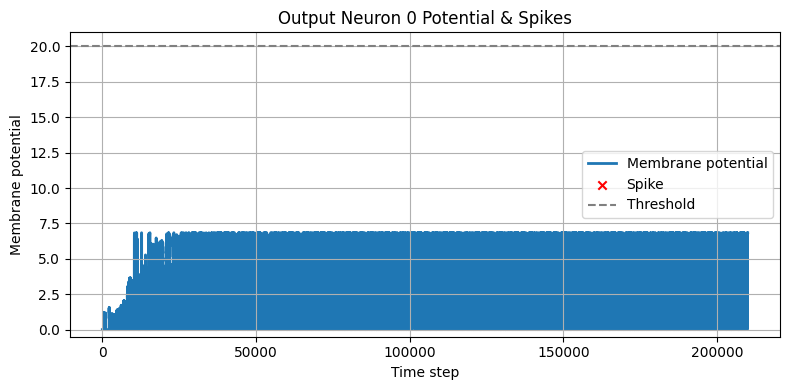

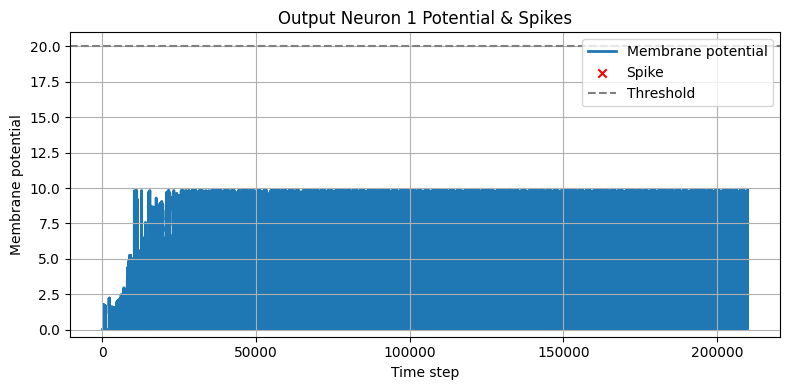

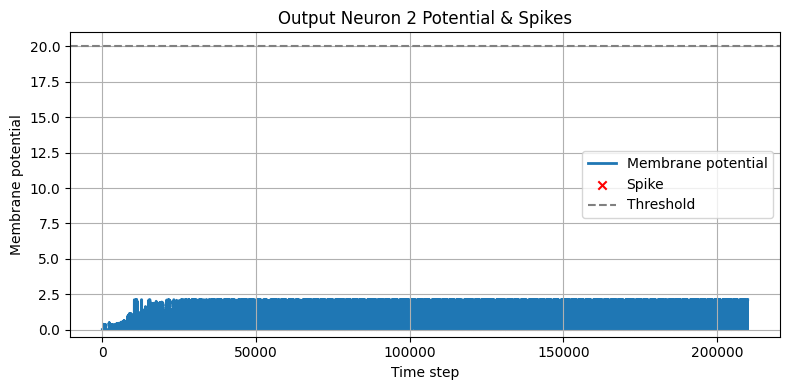

In [48]:
classifier.train(X_train, y_train)

In [49]:
classifier.test(X_test, y_test, True)

Predicted: 0, Correct: 1
Predicted: 0, Correct: 0
Predicted: 0, Correct: 2
Predicted: 0, Correct: 1
Predicted: 0, Correct: 1
Predicted: 0, Correct: 0
Predicted: 0, Correct: 1
Predicted: 0, Correct: 2
Predicted: 0, Correct: 1
Predicted: 0, Correct: 1
Predicted: 0, Correct: 2
Predicted: 0, Correct: 0
Predicted: 0, Correct: 0
Predicted: 0, Correct: 0
Predicted: 0, Correct: 0
Predicted: 0, Correct: 1
Predicted: 0, Correct: 2
Predicted: 0, Correct: 1
Predicted: 0, Correct: 1
Predicted: 0, Correct: 2
Predicted: 0, Correct: 0
Predicted: 0, Correct: 2
Predicted: 0, Correct: 0
Predicted: 0, Correct: 2
Predicted: 0, Correct: 2
Predicted: 0, Correct: 2
Predicted: 0, Correct: 2
Predicted: 0, Correct: 2
Predicted: 0, Correct: 0
Predicted: 0, Correct: 0
Predicted: 0, Correct: 0
Predicted: 0, Correct: 0
Predicted: 0, Correct: 1
Predicted: 0, Correct: 0
Predicted: 0, Correct: 0
Predicted: 0, Correct: 2
Predicted: 0, Correct: 1
Predicted: 0, Correct: 0
Predicted: 0, Correct: 0
Predicted: 0, Correct: 0


42.22222222222222